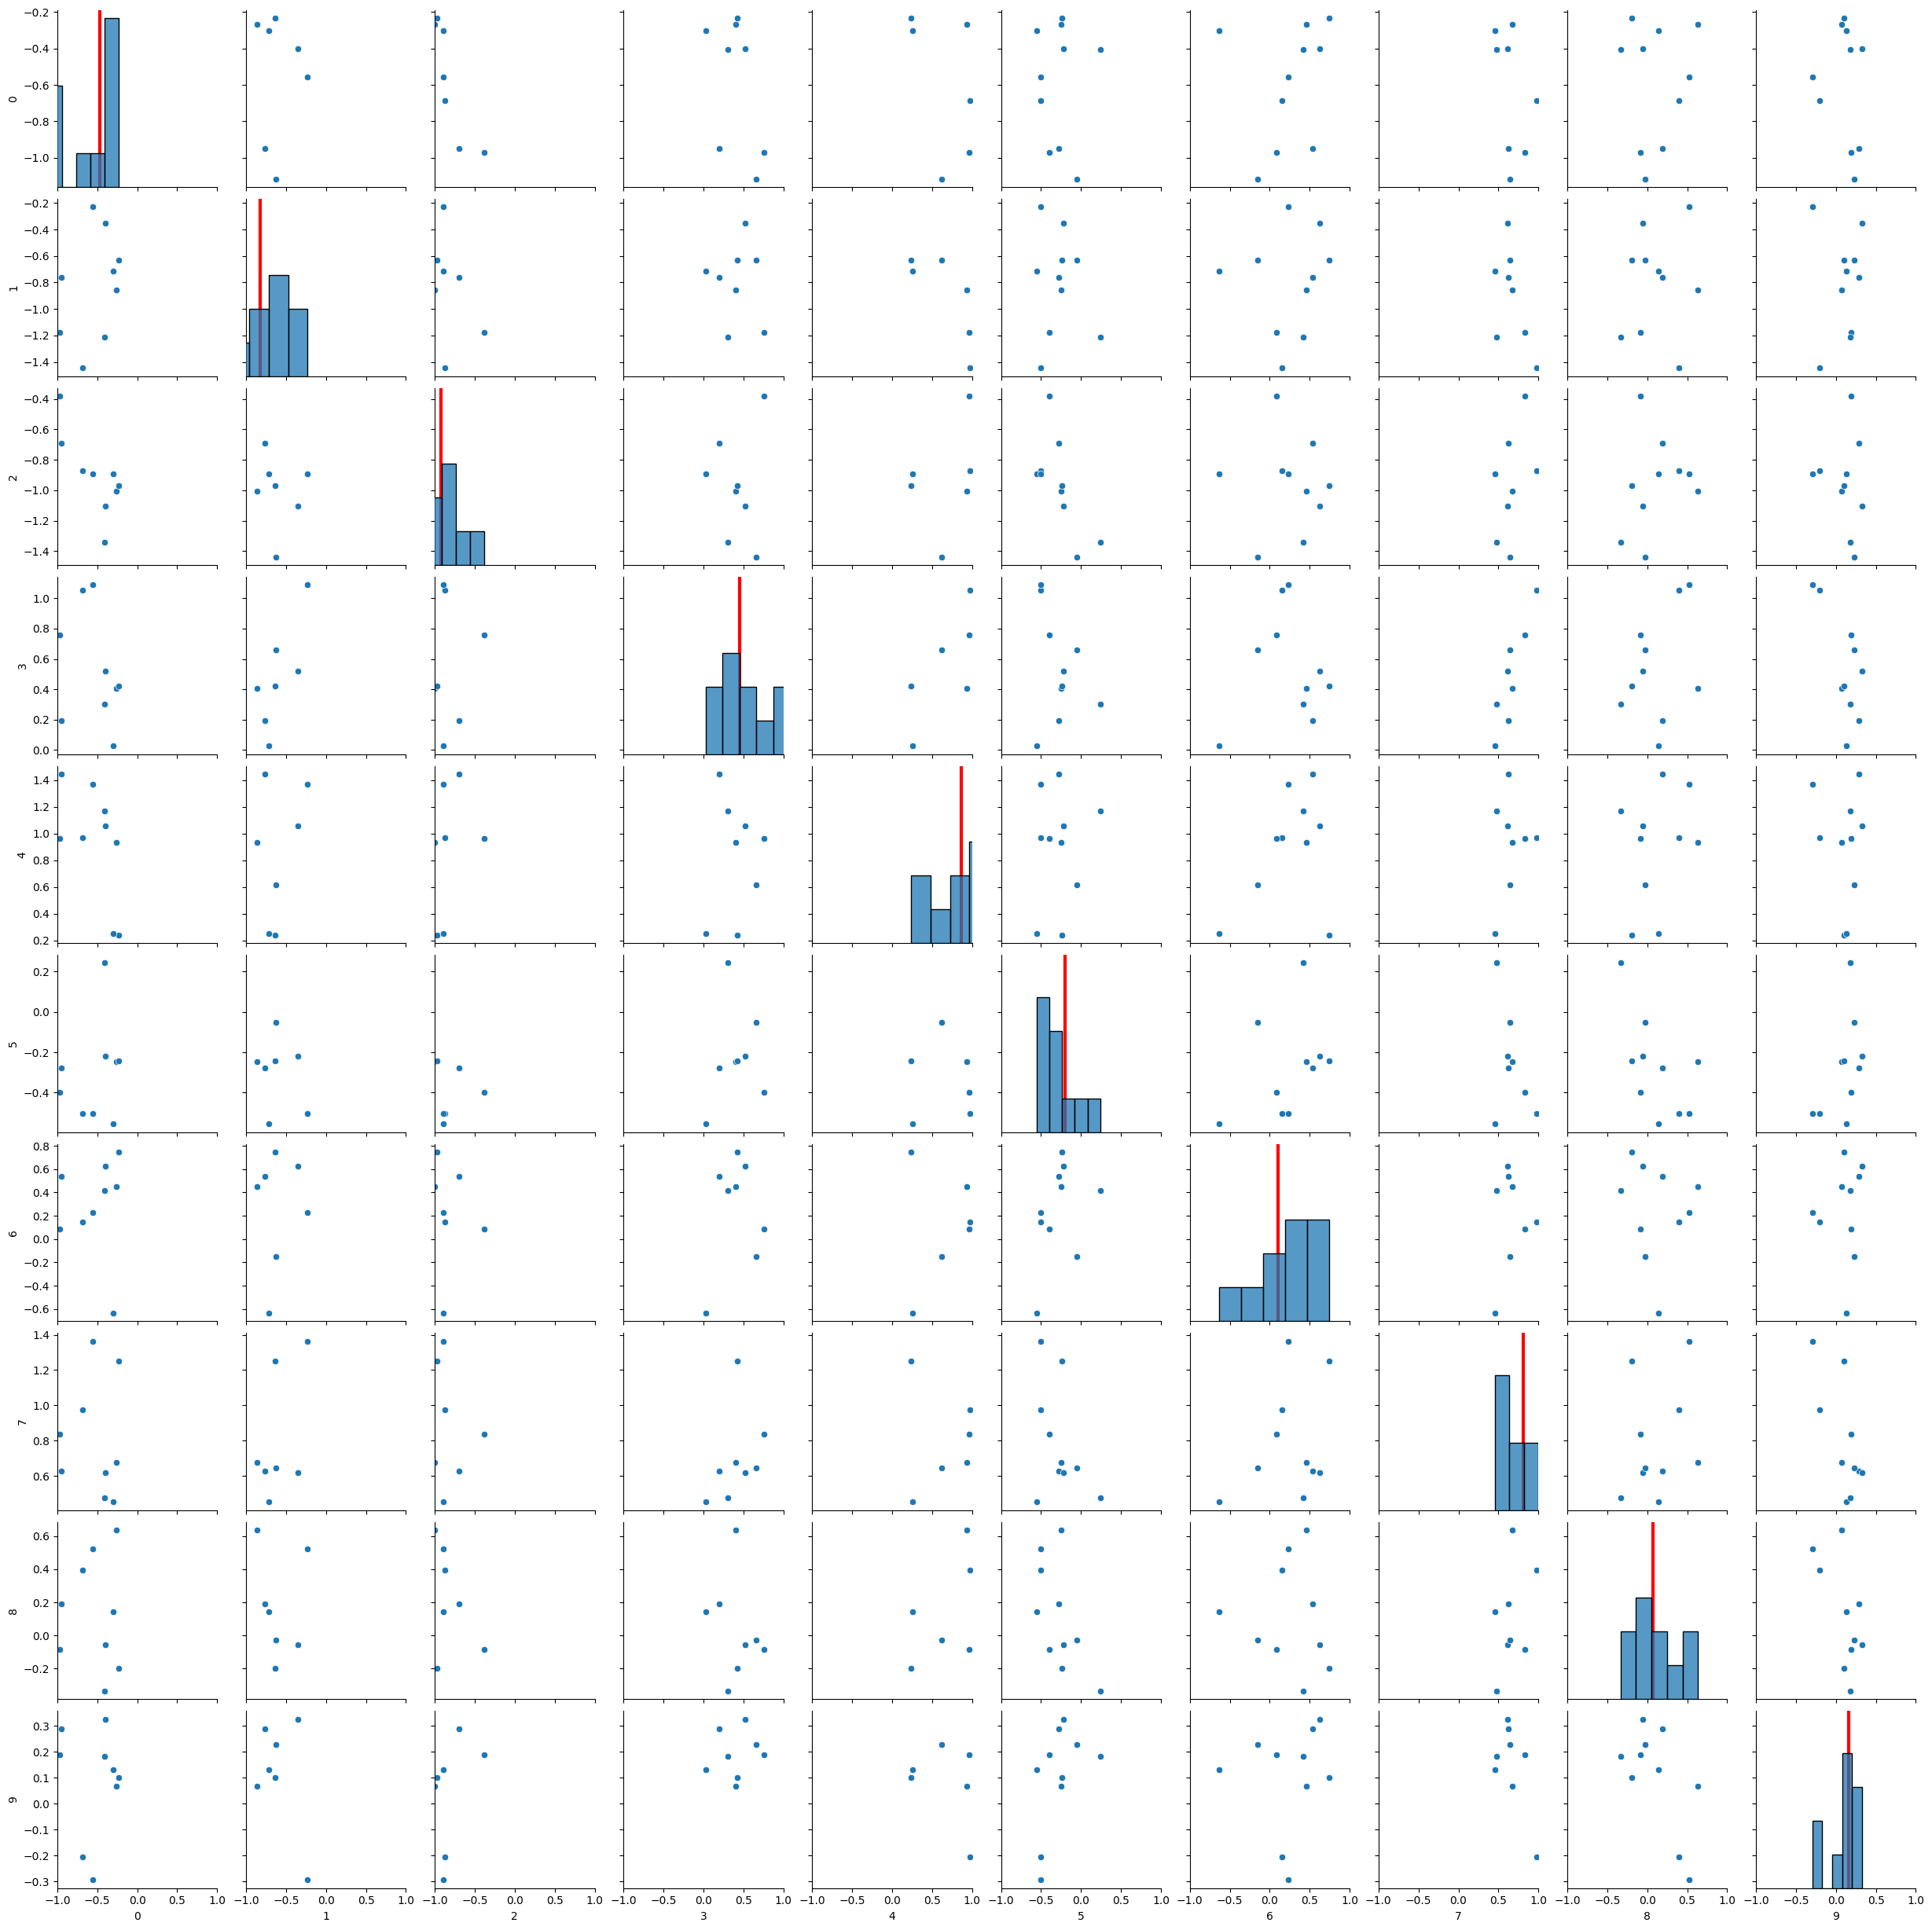

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle
import sbi.utils as utils
import torch
from sbi.inference import MCMCPosterior
from scipy.special import logsumexp
from seaborn import histplot

import sys  
sys.path.insert(1, '../')
from collective_posterior import CollectivePosterior
from simulators import GLU, GLU_wrapper
import sbibm
from seaborn import pairplot
import warnings
warnings.simplefilter('ignore', FutureWarning)


prior = sbibm.get_task('gaussian_linear_uniform').get_prior_dist()
t = prior.sample((1,))[0]

X = GLU_wrapper(reps=10, parameters=t)
g = pairplot(pd.DataFrame(X.numpy()))
for i in range(len(t)):
    g.axes[i,i].axvline(t[i],color='red', linewidth=3)
    g.axes[i,i].set_xlim(prior.base_dist.low[i], prior.base_dist.high[i])

In [14]:
from simulators import WF
from sbi.utils import BoxUniform
import torch
import pickle
import time
from sbi.inference import NPSE, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

prior = BoxUniform(low=torch.tensor([-2, -7, -8]), high=torch.tensor([0, -2, -2]))

# time
start = time.time()

# Define the prior and simulator
sim = 'WF'
simulator = WF

# inference
# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior)

# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(simulator, prior, prior_returns_numpy)

# Inference
inference = NPSE(prior, sde_type='ve')

theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=1000)
density_estimator = inference.append_simulations(theta, x).train(training_batch_size=200, stop_after_epochs=2)
posterior = inference.build_posterior(density_estimator)

# time
end = time.time()
print(f'Inference time: {end - start} seconds')

posterior.set_default_x(X).sample((100,)).mean(0)

  0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 35 epochs.Inference time: 117.93358206748962 seconds


/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/sbi/utils/user_input_checks.py:585: UserWarning: An x with a batch size of 10 was passed. Unless you are using `sample_batched` or `log_prob_batched`, this will be interpreted as a batch of independent and identically distributed data X={x_1, ..., x_n}, i.e., data generated based on the same underlying(unknown) parameter. The resulting posterior will be with respect to the entire batch, i.e,. p(theta | X).
  warn_on_batched_x(batch_size=input_x_shape[0])


Drawing 100 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

NotImplementedError: Score accumulation for IID data is not yet implemented.

In [16]:
posterior.set_default_x(X[0,:]).sample((100,)).mean(0)

Drawing 100 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

tensor([-1.0186, -4.1275, -5.2765])

In [2]:
posterior_cp = pickle.load(open('posteriors/posterior_GLU_10000_20.pkl', 'rb'))
epsilon = -10000
op = CollectivePosterior(prior, posterior_cp, X, 1, epsilon)
print(op.get_log_C())

tensor(-50.4789)


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/GLU/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)


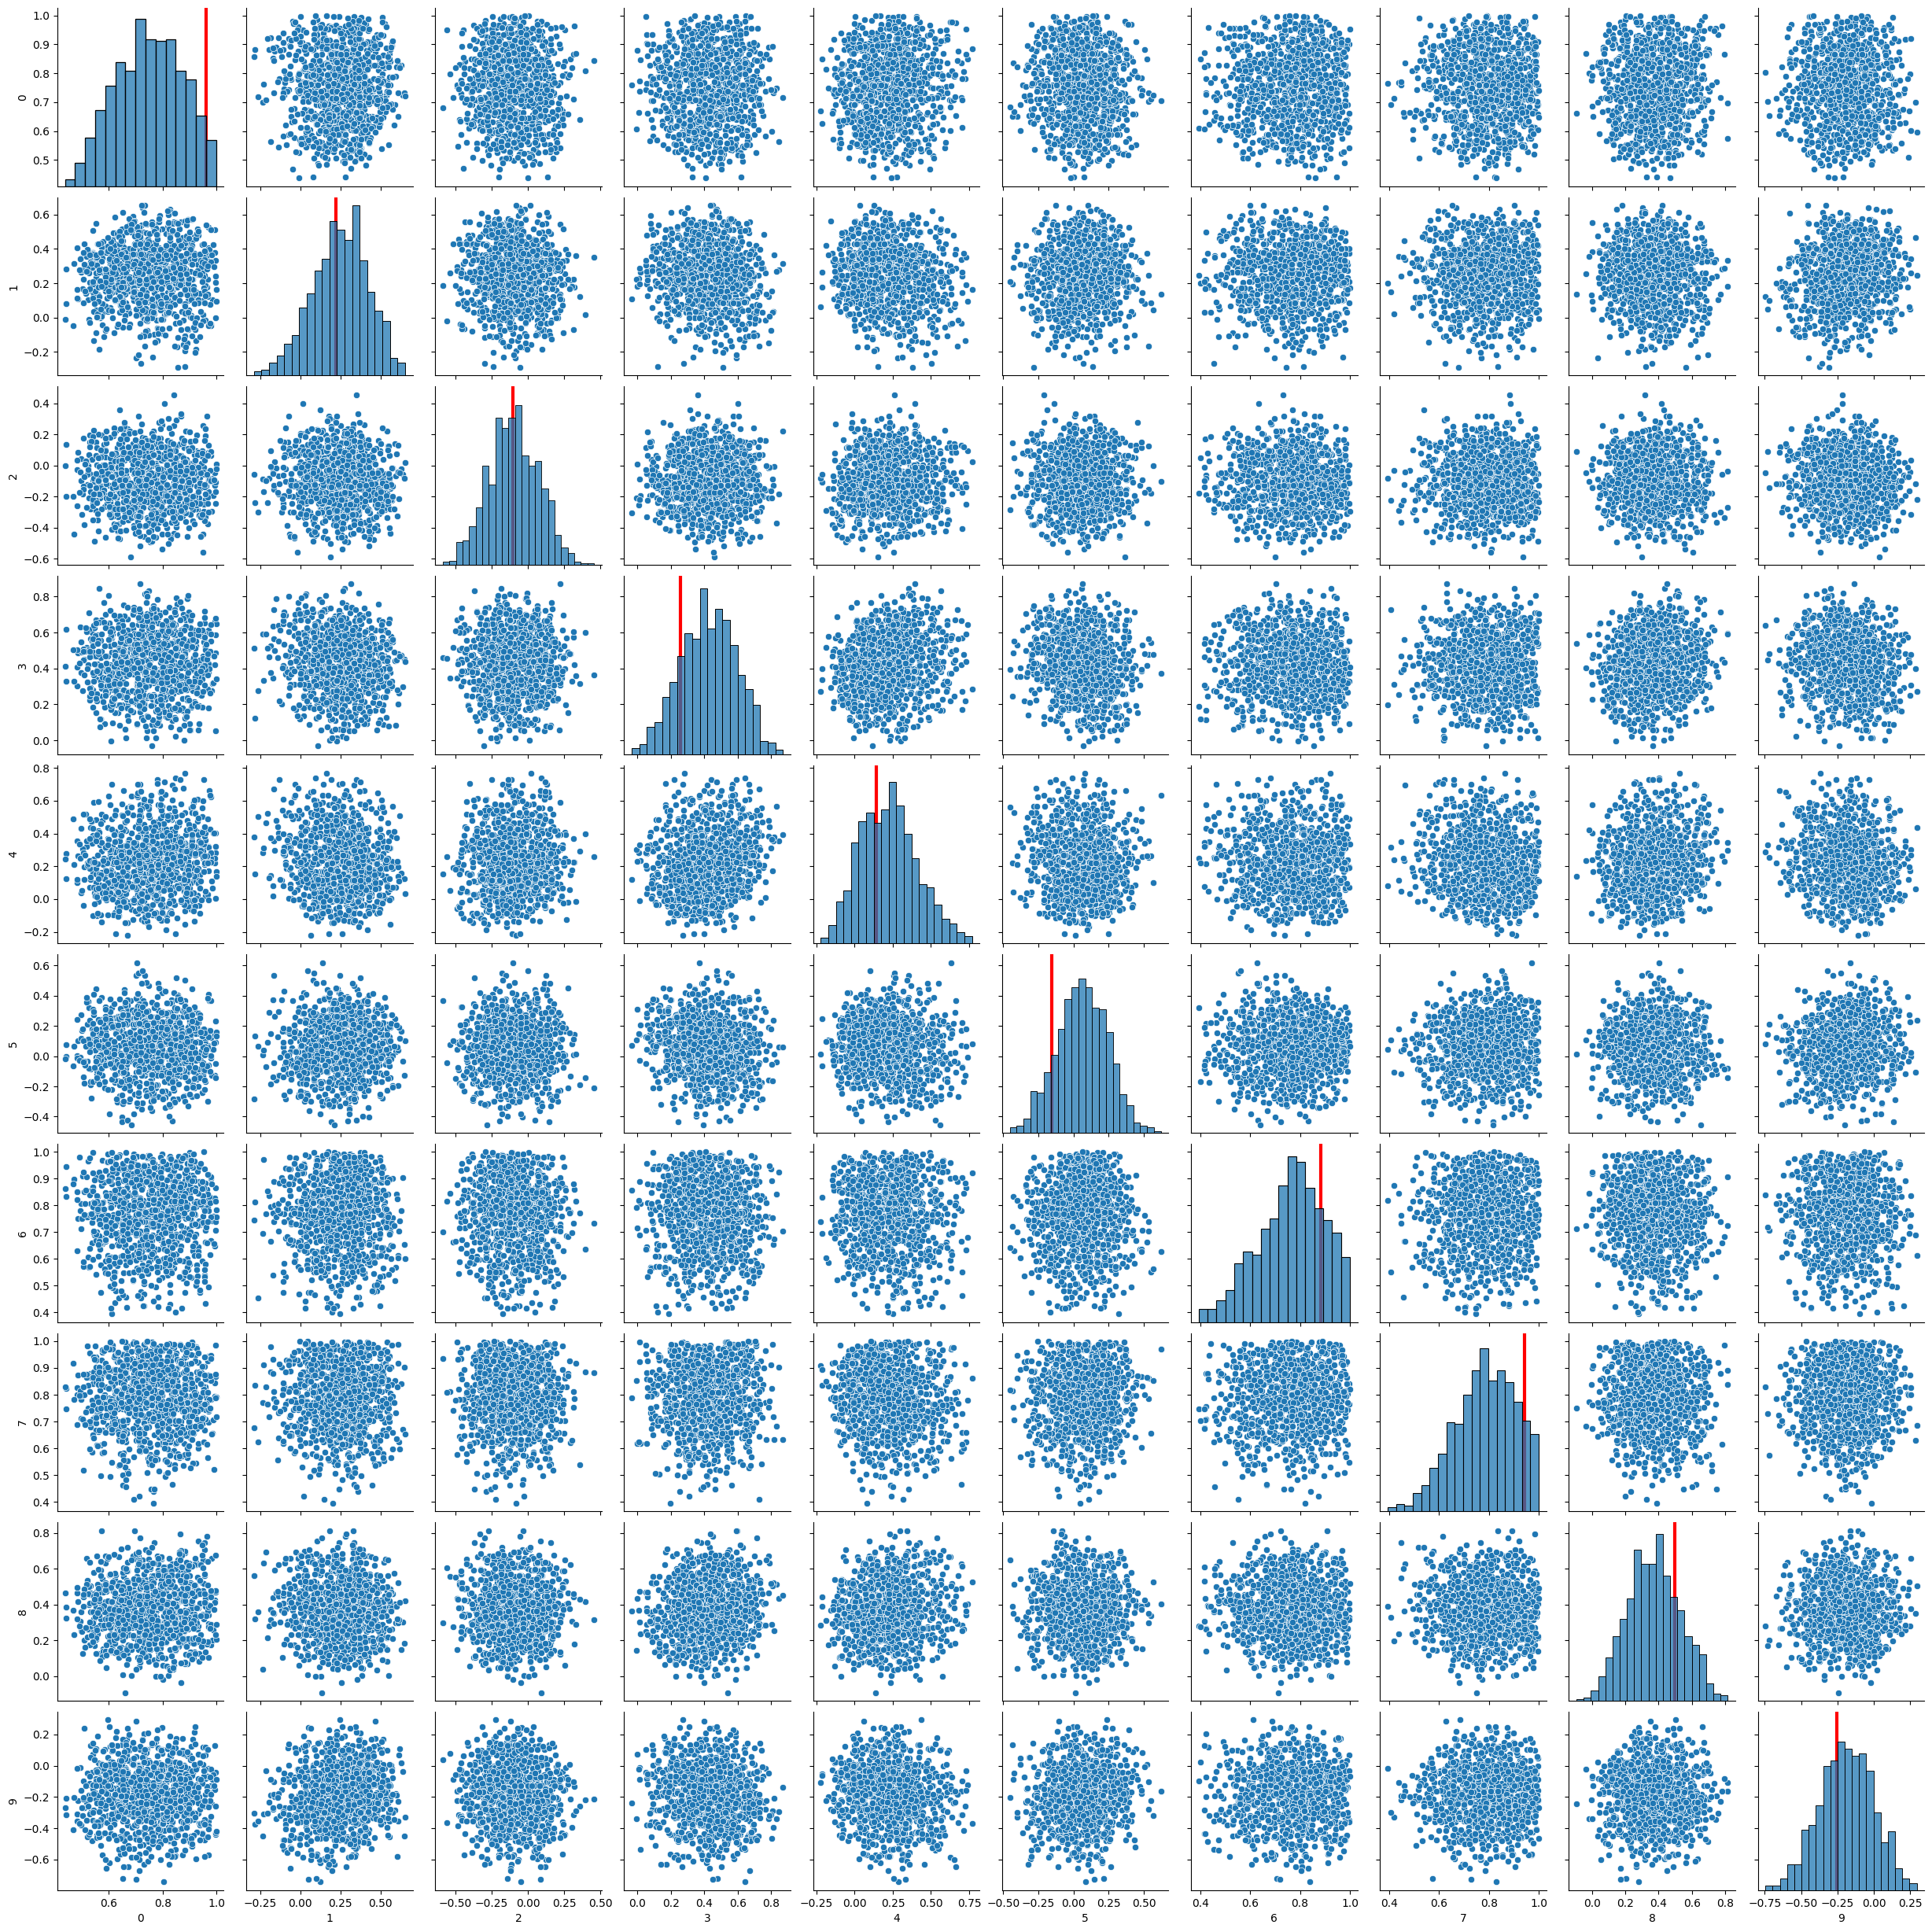

In [3]:
g = pairplot(pd.DataFrame(op.sample(1000).numpy()))
for i in range(len(t)):
    g.axes[i,i].axvline(t[i],color='red', linewidth=3)

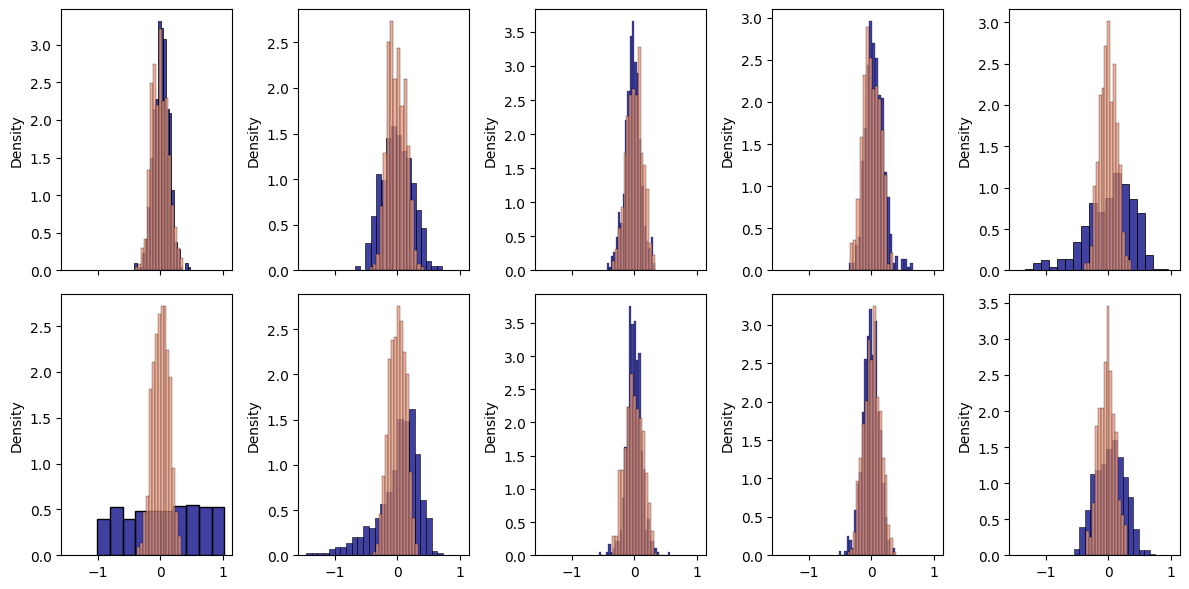

In [2]:
def plot_accuracy(acc_path, ax, color):
    res = pd.read_csv(acc_path, index_col=0, dtype='float')
    res = torch.from_numpy(np.array(res))
    for i in range(10):
        histplot(res[:,i],ax=ax[i%2, i//2], stat='density', color=color)
    return

n_params=10
fig, ax = plt.subplots(2,n_params//2, figsize=(12,6), tight_layout=True, sharex=True)


iid_acc = 'tests/accus_GLU_iid.csv'
plot_accuracy(iid_acc, ax, color='navy')

cp_acc = 'tests/accus_GLU.csv'
plot_accuracy(cp_acc, ax, color='darksalmon')


/tmp/ipykernel_1141508/2733983701.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  H,X1 = np.histogram(covs, bins = 100, normed = True)
/tmp/ipykernel_1141508/2733983701.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  H,X1 = np.histogram(covs, bins = 100, normed = True)


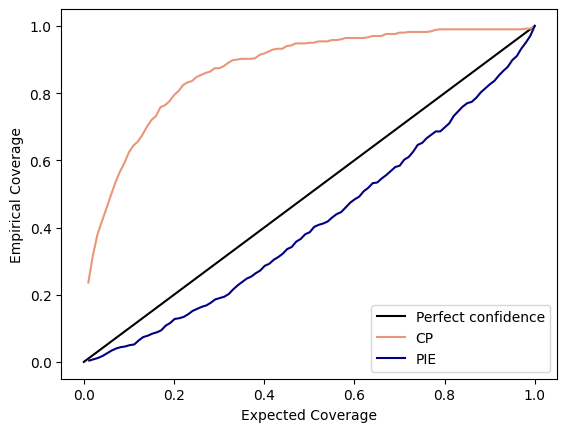

In [3]:
def plot_covs(covs, ax, label, color):
    H,X1 = np.histogram(covs, bins = 100, normed = True)
    dx = X1[1] - X1[0]
    F1 = np.cumsum(H)*dx
    ax.plot(X1[1:], F1, label = label, color=color)

    ax.set_xlabel('Expected Coverage')
    ax.set_ylabel('Empirical Coverage')
    ax.legend()
    return

fig, ax = plt.subplots()
ax.plot(np.linspace(0,1,100),np.linspace(0,1,100), color='k', label='Perfect confidence')
covs = pd.read_csv('tests/covs_GLU.csv', index_col=0, dtype='float')
plot_covs(covs,ax,label='CP',color='darksalmon')

covs_iid = pd.read_csv('tests/covs_GLU_iid.csv', index_col=0, dtype='float')
plot_covs(covs_iid,ax,label='PIE',color='navy')

In [8]:
sbi_posterior = pickle.load(open(f'posteriors/posterior_iid_GLU_10000_20.pkl', 'rb'))
res_iid = torch.zeros_like(thetas)
for i in range(len(thetas)):
    theta = thetas[i]
    Xs = GLU_wrapper(10, theta)
    m = sbi_posterior.set_default_x(Xs).sample((200,)).mean(0)
    res_iid[i] = m - theta
    print(i)

/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/sbi/utils/user_input_checks.py:585: UserWarning: An x with a batch size of 10 was passed. Unless you are using `sample_batched` or `log_prob_batched`, this will be interpreted as a batch of independent and identically distributed data X={x_1, ..., x_n}, i.e., data generated based on the same underlying(unknown) parameter. The resulting posterior will be with respect to the entire batch, i.e,. p(theta | X).
  warn_on_batched_x(batch_size=input_x_shape[0])


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

0


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

1


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

2


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

3


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

4


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

5


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

6


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

7


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

8


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

9


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

10


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

11


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

12


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

13


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

14


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

15


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

16


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

17


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

18


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

19


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

20


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

21


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

22


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

23


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

24


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

25


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

26


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

27


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

28


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

29


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

30


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

31


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

32


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

33


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

34


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

35


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

36


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

37


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

38


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

39


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

40


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

41


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

42


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

43


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

44


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

45


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

46


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

47


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

48


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

49


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

50


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

51


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

52


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

53


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

54


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

55


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

56


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

57


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

58


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

59


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

60


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

61


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

62


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

63


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

64


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

65


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

66


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

67


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

68


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

69


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

70


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

71


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

72


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

73


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

74


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

75


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

76


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

77


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

78


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

79


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

80


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

81


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

82


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

83


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

84


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

85


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

86


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

87


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

88


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

89


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

90


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

91


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

92


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

93


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

94


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

95


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

96


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

97


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

98


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

99


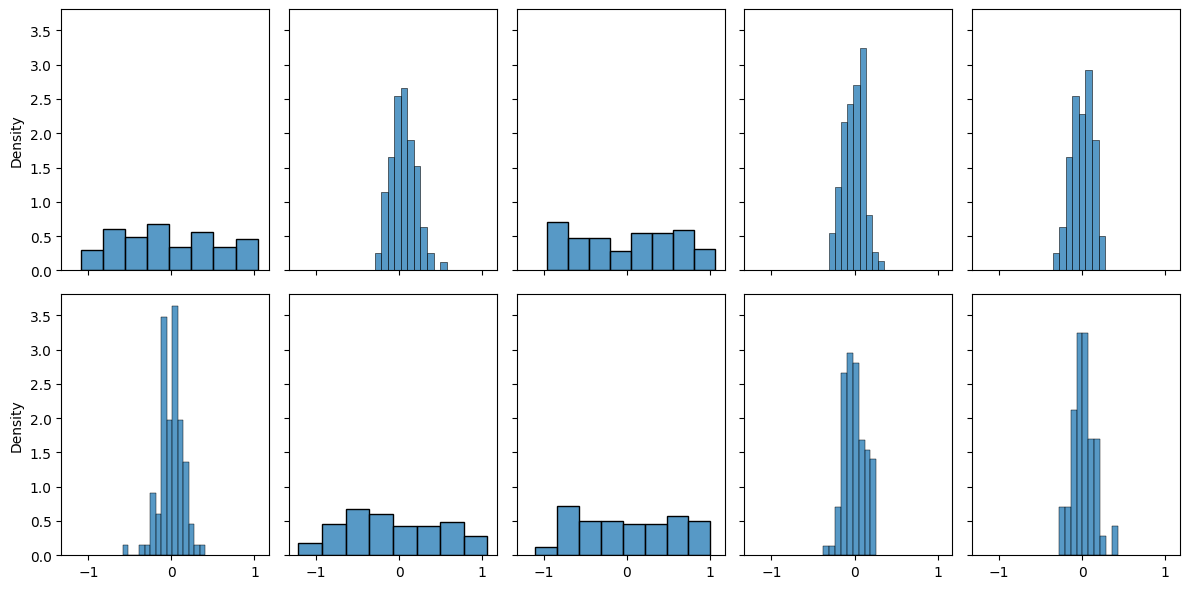

In [9]:
fig, ax = plt.subplots(2,5, figsize=(12,6), tight_layout = True, sharex=True, sharey=True)

for i in range(10):
    histplot(res_iid[:,i],ax=ax[i//5,i%5], stat='density')

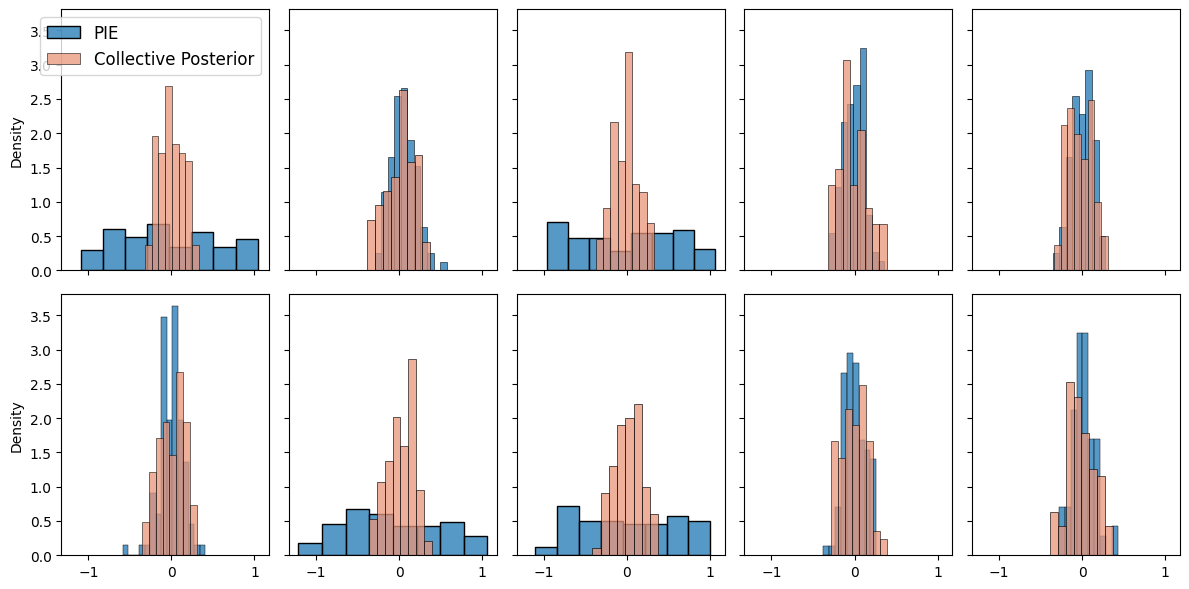

In [10]:
# Comparing methods

from seaborn import histplot
fig, ax = plt.subplots(2,5, figsize=(12,6), tight_layout = True, sharex=True, sharey=True)
# res_cp = np.array(pd.read_csv('tests/test_eval_cp_WF_10000_20.csv',index_col=0))
# res_iid = np.array(pd.read_csv('tests/test_eval_iid_WF_10000_20.csv',index_col=0))

# PIE
for i in range(10):
    histplot(res_iid[:,i],ax=ax[i//5,i%5], stat='density', label='PIE')
# CP
for i in range(10):
    histplot(res_cp[:,i],ax=ax[i//5,i%5], stat='density', color='darksalmon', label='Collective Posterior')

# ax[0].set_xlabel('GAP1 CNV \nselection coefficient', fontsize=12)
# ax[1].set_xlabel('GAP1 CNV \nformation rate', fontsize=12)
# ax[0].set_ylabel('Density', fontsize=12)
# ax[1].set_ylabel('Density', fontsize=12)

ax[0,0].legend(fontsize=12)


In [9]:
# COVERAGE

def coverage(posterior, thetas):
    covs = []
    for i in range(len(thetas)):
        cp = CollectivePosterior(prior=prior, amortized_posterior=posterior, log_C=1, Xs=GLU_wrapper(10, thetas[i]),epsilon=-10000)
        cp.get_log_C()
        samples = cp.sample(200)
        params = torch.tensor(thetas[i,:], dtype=torch.float32)
        covs.append((cp.log_prob(samples) > cp.log_prob(params)).sum()/200)
        print(i)
    return np.array(covs)

thetas = prior.sample((200,))
covs_cp = coverage(posterior_cp, thetas)

/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/GLU/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_965544/3541227875.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = torch.tensor(thetas[i,:], dtype=torch.float32)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [6]:
def coverage_old(posterior, conf_levels, thetas):
    covs = torch.empty(len(thetas),len(conf_levels), len(thetas[0]))
    for i in range(len(thetas)):
        cp = CollectivePosterior(prior=prior, amortized_posterior=posterior, log_C=1, Xs=GLU_wrapper(10, thetas[i]),epsilon=-10000)
        cp.get_log_C()
        num_samps = 200
        samples = cp.sample(num_samps)
        params = torch.tensor(thetas[i,:], dtype=torch.float32)
        sorted_probs, ind = torch.sort(cp.log_prob(samples), descending=True)
        for j in range(len(conf_levels)):
            conf_level = conf_levels[j]   
            samples_trimmed = samples[ind]
            probs = samples_trimmed[:int(conf_level*num_samps)+1]
            # hdi = [torch.quantile(samples, (1-conf_level)/2, 0), torch.quantile(samples,(1+conf_level)/2, 0)]
            hdi = [probs.min(0)[0], probs.max(0)[0]]
            covs[i,j] = ((params > hdi[0])*(params < hdi[1]))
        print(i)
    return covs, np.array(covs.mean(0))

thetas = prior.sample((100,))
covs_cp = coverage_old(posterior_cp, [0.25,0.5,0.8,0.95], thetas)

/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/GLU/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_2647104/2709824373.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = torch.tensor(thetas[i,:], dtype=torch.float32)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [12]:
covs_cp[1]

array([[0.89, 0.9 , 0.93, 0.91, 0.9 , 0.9 , 0.96, 0.91, 0.91, 0.9 ],
       [0.96, 0.96, 0.96, 0.97, 0.94, 0.95, 0.99, 0.96, 0.94, 0.94],
       [0.99, 0.98, 0.98, 0.99, 0.97, 0.97, 1.  , 0.97, 0.97, 0.97],
       [1.  , 0.98, 0.98, 0.99, 0.98, 0.98, 1.  , 0.97, 0.97, 0.99]],
      dtype=float32)

/tmp/ipykernel_965544/1141272028.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  H,X1 = np.histogram(covs_cp, bins = 100, normed = True)


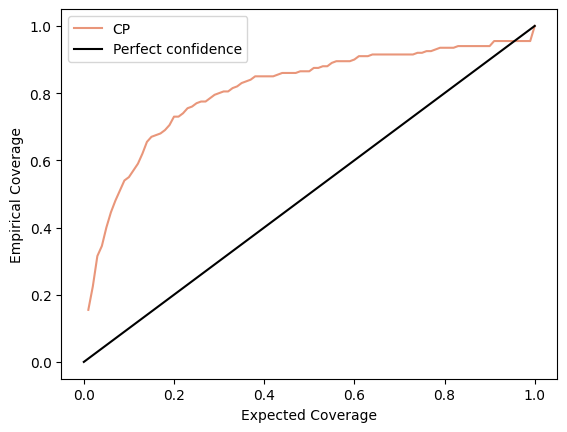

In [13]:

H,X1 = np.histogram(covs_cp, bins = 100, normed = True)
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx
plt.plot(X1[1:], F1, label = 'CP', color='darksalmon')

plt.plot(np.linspace(0,1,100),np.linspace(0,1,100), color='k', label='Perfect confidence')

plt.xlabel('Expected Coverage')
plt.ylabel('Empirical Coverage')
plt.legend()

In [14]:
def coverage_iid(posterior, thetas):
    covs = []
    for i in range(len(thetas)):
        params = torch.tensor(thetas[i,:], dtype=torch.float32)
        X = GLU_wrapper(10, thetas[i])
        samples = posterior.set_default_x(X).sample((200,))
        covs.append((posterior.log_prob(samples) > posterior.log_prob(params)).sum()/200)
        print(i)
    return np.array(covs)

sbi_posterior = pickle.load(open(f'posteriors/posterior_iid_GLU_10000_20.pkl', 'rb'))
covs_iid = coverage_iid(sbi_posterior, thetas)

/tmp/ipykernel_965544/2289350175.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = torch.tensor(thetas[i,:], dtype=torch.float32)


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

0


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

1


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

2


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

3


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

4


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

5


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

6


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

7


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

8


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

9


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

10


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

11


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

12


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

13


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

14


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

15


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

16


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

17


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

18


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

19


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

20


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

21


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

22


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

23


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

24


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

25


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

26


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

27


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

28


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

29


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

30


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

31


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

32


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

33


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

34


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

35


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

36


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

37


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

38


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

39


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

40


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

41


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

42


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

43


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

44


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

45


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

46


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

47


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

48


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

49


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

50


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

51


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

52


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

53


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

54


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

55


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

56


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

57


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

58


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

59


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

60


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

61


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

62


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

63


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

64


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

65


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

66


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

67


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

68


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

69


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

70


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

71


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

72


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

73


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

74


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

75


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

76


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

77


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

78


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

79


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

80


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

81


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

82


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

83


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

84


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

85


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

86


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

87


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

88


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

89


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

90


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

91


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

92


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

93


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

94


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

95


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

96


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

97


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

98


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

99


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

100


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

101


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

102


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

103


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

104


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

105


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

106


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

107


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

108


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

109


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

110


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

111


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

112


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

113


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

114


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

115


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

116


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

117


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

118


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

119


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

120


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

121


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

122


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

123


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

124


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

125


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

126


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

127


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

128


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

129


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

130


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

131


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

132


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

133


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

134


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

135


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

136


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

137


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

138


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

139


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

140


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

141


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

142


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

143


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

144


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

145


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

146


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

147


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

148


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

149


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

150


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

151


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

152


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

153


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

154


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

155


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

156


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

157


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

158


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

159


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

160


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

161


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

162


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

163


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

164


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

165


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

166


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

167


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

168


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

169


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

170


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

171


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

172


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

173


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

174


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

175


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

176


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

177


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

178


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

179


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

180


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

181


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

182


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

183


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

184


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

185


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

186


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

187


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

188


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

189


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

190


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

191


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

192


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

193


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

194


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

195


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

196


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

197


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

198


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

199


/tmp/ipykernel_965544/3063945101.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  H,X1 = np.histogram(covs_iid, bins = 100, normed = True)


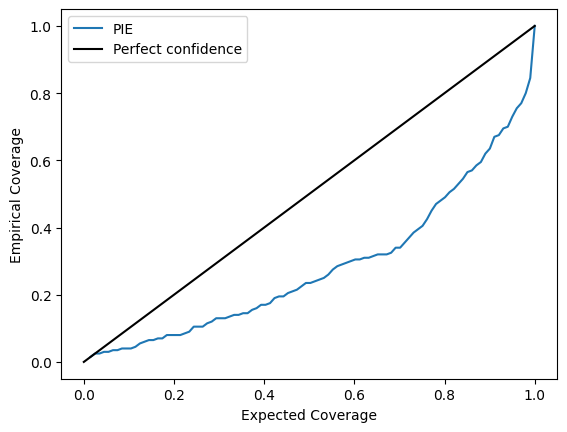

In [15]:
H,X1 = np.histogram(covs_iid, bins = 100, normed = True)
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx
plt.plot(X1[1:], F1, label = 'PIE')

plt.plot(np.linspace(0,1,100),np.linspace(0,1,100), color='k', label='Perfect confidence')

plt.xlabel('Expected Coverage')
plt.ylabel('Empirical Coverage')
plt.legend()

/tmp/ipykernel_965544/3533755502.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  H,X1 = np.histogram(covs_iid, bins = 100, normed = True)
/tmp/ipykernel_965544/3533755502.py:6: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  H,X1 = np.histogram(covs_cp, bins = 100, normed = True)


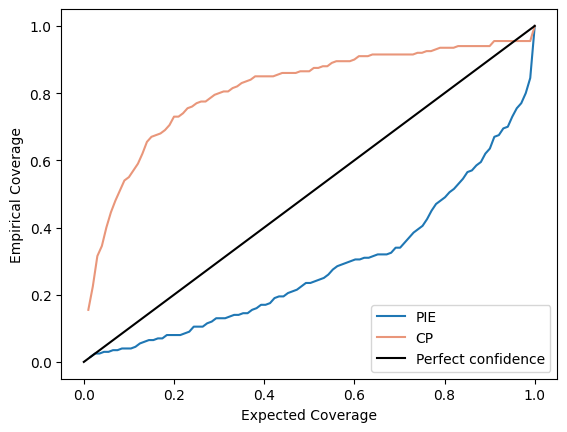

In [16]:
H,X1 = np.histogram(covs_iid, bins = 100, normed = True)
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx
plt.plot(X1[1:], F1, label = 'PIE')

H,X1 = np.histogram(covs_cp, bins = 100, normed = True)
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx
plt.plot(X1[1:], F1, label = 'CP', color='darksalmon')

plt.plot(np.linspace(0,1,100),np.linspace(0,1,100), color='k', label='Perfect confidence')


plt.xlabel('Expected Coverage')
plt.ylabel('Empirical Coverage')
plt.legend()